# The k-means algorithm
Espen Fanavoll

K-means is a machine learning algorithm for *clustering* i.e. grouping unlabeled data poins based on closeness in their feature space. The features should be numerical (and preferally continous). Binary features do not help this algorithm much.

K-means should not be confused with the similarily named k-nearest-neighbors algorithm, which is a classification algorithm for labeled data. 

In Python, KMeans is available from sklearn.cluster. The base functionality of the algorithm is relatively easy to code, and will be demonstrated in this notebook on 2D clustered data.

In [1]:
import os 
#os.chdir('d\\code\\py\\k-means\\')
from IPython.display import HTML, IFrame
IFrame('k-means_1.gif', width=550, height=350)

## Generate some clustered data

First, we will generate some random clustered data points to demonstrate the algorithm

In [2]:
import numpy as np
from matplotlib import pyplot as plt
def generate_clusters(k, limits=(0, 10, 0, 10), size=(50, 50), spread=1, rseed=False):
  if rseed: # Set the random seed for repeatability
    np.random.seed(rseed)
  sizes = np.random.randint(size[0], size[1], k) # Cluster sizes
  print(sizes)
  centers_x = np.random.uniform(limits[0], limits[1], k)
  centers_y = np.random.uniform(limits[2], limits[3], k)
  centers = np.array(list(zip(centers_x, centers_y)))
  x = []
  y = []
  labels = []
  for i in range(k):
      x += np.random.normal(loc = centers_x[i], scale = spread, size = sizes[i]).tolist()
      y += np.random.normal(loc = centers_y[i], scale = spread, size = sizes[i]).tolist()
      labels += [i] * sizes[i]
  colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
  colors = colors_list[:k]
  return np.array(list(zip(x,y))), labels, centers, colors


[83 94 95 86]


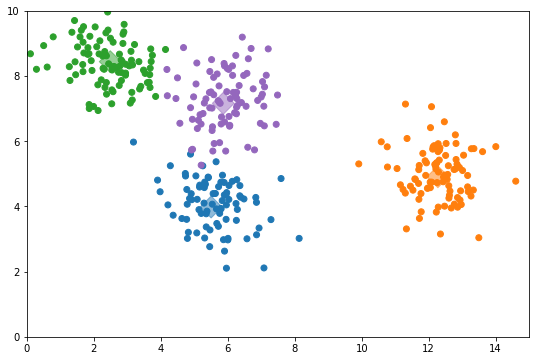

In [3]:
k = 4
xy, labels, centers, colors = generate_clusters(k,
                               limits = (1.5, 12.5, 1.5, 8.5), 
                               size = (80, 100),
                               spread = 0.8,
                               rseed = 5)
# Plot the created clusters
x = xy[:,0]
y = xy[:,1]
f, ax = plt.subplots(figsize = (9,6))
ax.scatter(x, y, c = [colors[i] for i in labels])
ax.scatter(centers[:,0], centers[:,1], marker='D', s = 240 ,c = colors, alpha = 0.5)
ax.set(xlim=(0,15), ylim=(0,10))
plt.show()

## The KMeans algorithm
The k-means algorithm can be summarized in these steps:

0. Randomly generate *k* centroids
1. Assign all data points to the nearest centroid
2. Recalculate new centroids from the *mean* position of the data points
3. Repeat steps 2 and 3 until the centroids stop moving

Prediction of new data points is simply done by finding the nearest centroid to that point.

First we need a formula to calculate the distance between two points. In this case we will use the "ordinary" euclidian distance, though other distance models (e.g. manhattan) could be used instead.


In [4]:
# Euclidian distance formula, works for any number of dimensions
def distance(a, b, s=0):
  for ai, bi in zip(a,b):
    s += (ai - bi) ** 2
  return s ** 0.5

Now generate some random centroids, and assign data points. Then, the new centroids are calculated from the newly labelled sets.

In [5]:
np.random.seed(3) # Set the random seed for repeatability
centroid_x = np.random.uniform(min(x), max(x), k)
centroid_y = np.random.uniform(min(y), max(y), k)
centroids = np.array(list(zip(centroid_x, centroid_y)))

In [6]:
cluster = np.zeros(len(x), dtype = np.int8)
distances = np.zeros(k)

# Assign to the closest centroid
for i in range(len(x)):
  for j in range(k):
    distances[j] = distance((x[i], y[i]) , centroids[j])
  cluster[i] = np.argmin(distances)

# Calculate new centroids
new_centroids = np.zeros(centroids.shape)
for i in range(k):
  points = xy[cluster == i]
  if points.shape[0] == 0: # We need to account for that one centroid may have no points assigned
    new_centroids[i] = centroids[i]
  else: 
    new_centroids[i] = points.mean(axis=0)

# Reassign to the new closest centroid
new_cluster = np.zeros(len(x), dtype = np.int8)
for i in range(len(x)):
  for j in range(k):
    distances[j] = distance((x[i], y[i]) , new_centroids[j])
  new_cluster[i] = np.argmin(distances)

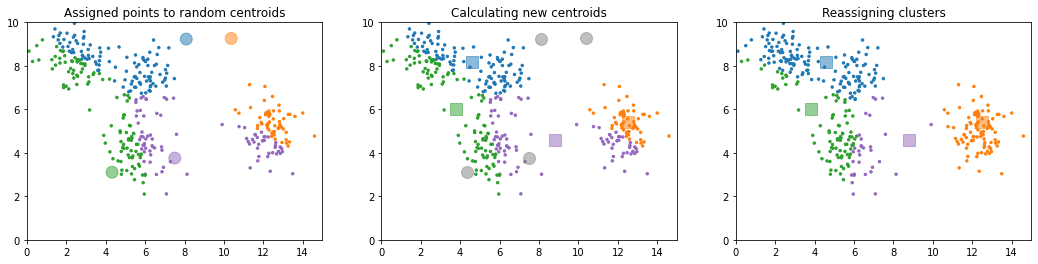

In [7]:
# Plot the created clusters
f, (ax1, ax2, ax3) = plt.subplots(figsize = (18,4), nrows=1, ncols=3)

ax1.scatter(x, y, c = [colors[i] for i in cluster], s=6)
ax1.scatter(centroids[:,0], centroids[:,1], marker = 'o', s= 144, c=colors, alpha = 0.5)
ax1.set(xlim=(0,15), ylim=(0,10), title='Assigned points to random centroids')

ax2.scatter(x, y, c = [colors[i] for i in cluster], s=6)
ax2.scatter(centroids[:,0], centroids[:,1], marker = 'o', s= 144, c='gray', alpha = 0.5)
ax2.scatter(new_centroids[:,0], new_centroids[:,1], marker = 's', s= 144, c=colors, alpha = 0.5)
ax2.set(xlim=(0,15), ylim=(0,10), title = 'Calculating new centroids')

ax3.scatter(x, y, 
    c = [colors[i] for i in new_cluster], 
    s=6)
ax3.scatter(new_centroids[:,0], new_centroids[:,1], marker = 's', s= 144, c=colors, alpha = 0.5)
ax3.set(xlim=(0,15), ylim=(0,10), title='Reassigning clusters')

plt.show()

### Generalizing the algorithm
This can take quite a few steps to reach convergence. We can generalize the code in order to loop until completion, and include some extra code to animate the process.

In [8]:
from celluloid import Camera # Simplified interface for matplotlib animation 
from copy import deepcopy # Storing independent copies

def random_centroids(k, data):
  le, dim = data.shape
  centroids = np.zeros(shape=(k, dim))
  for i in range(dim):
    centroids[:,i] = np.random.uniform(min(data[:,i]), max(data[:,i]), k)
  return centroids

def kmeans_2d_animate(data, k, rseed=False, animate=True, init = random_centroids):
  if data.shape[1] != 2:
    raise Exception('Input data must me 2-dimensional')
  if rseed:
    np.random.seed(rseed) # Set random seed for reproducibility
  if animate:
    f, ax = plt.subplots(figsize=(9, 6))
    camera = Camera(f)
    colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    colors = colors_list[:k]
    markers = ['D', 's'] # Alternating markers
  
  le, dim = data.shape
  centroids = init(k, data)
  cluster = np.zeros(le, dtype = np.int8)
  distances = np.zeros(k)
  centroids_old = np.zeros(centroids.shape)
  error = np.array([float('inf')]*k)
  counter = 0
  while error.any(): # Run until all error values are zero (centroids stopped moving)
    centroids_old = deepcopy(centroids)
    # Assign to the closest centroid
    for i in range(len(data)):
      for j in range(k):
        distances[j] = distance(data[i] , centroids[j])
      cluster[i] = np.argmin(distances)
    if animate:
      ax.scatter(data[:,0], data[:,1], c = [colors[i] for i in cluster])
      ax.scatter(centroids[:,0], centroids[:,1], marker = markers[counter%2], s= 240, c=colors, alpha = 0.5)
      ax.set(xlim=(0,15), ylim=(0,10))
      ax.text(0.5, 1.015, f'Step {counter}_1', transform=ax.transAxes)
      camera.snap()

    # Calculate new centroids
    for i in range(k):
      points = data[cluster == i]
      if points.shape[0] == 0: # We may need to account for that one centroid may have no points assigned
        centroids[i] = centroids[i]
      else: 
        centroids[i] = points.mean(axis=0)
      error[i] = distance(centroids[i], centroids_old[i])
    if animate:
      ax.scatter(data[:,0], data[:,1], c = [colors[i] for i in cluster])
      ax.scatter(centroids[:,0], centroids[:,1], marker = markers[(counter+1)%2], s= 240, c=colors, alpha = 0.5)
      #ax.scatter(centroids_old[:,0], centroids_old[:,1], marker = markers[(counter+1)%3], s= 240, c=colors, alpha = 0.5)
      ax.set(xlim=(0,15), ylim=(0,10))
      ax.text(0.5, 1.015, f'Step {counter}_2', transform=ax.transAxes)
      camera.snap()
    counter += 1
  if animate:
    anim = camera.animate(interval=250)
    plt.close()
  else:
    anim = None
  
  return anim, centroids, cluster  

In [10]:
anim, centroids, cluster = kmeans_2d_animate(xy, k=4, rseed=3)
print(centroids)
anim.save('k-means_2.gif', fps=4, writer='imagemagick')
HTML(anim.to_html5_video())

[[ 2.46259022  8.36798522]
 [12.29883636  5.00626611]
 [ 5.95721446  7.35011285]
 [ 5.61688849  4.14303508]]


## Evaluating the performance of the algorithm

The performance of the clustering algorithm can be measured by the tightness of the clusters, or *inertia*. This is the sum of the distances from each point to the nearest centroid. As such, this measurement can only be related to one specific dataset, and is not an absolute score of the model

In [ ]:
def calc_inertia(centroids, data):
  k = centroids.shape[0]
  inertia = 0
  distances = np.zeros(k)
  for i in range(data.shape[0]):
    for j in range(k):
      distances[j] = distance(data[i] , centroids[j])
    inertia += distances.min()
  return inertia

In [ ]:
print(calc_inertia(centroids, xy))

Because we also know the *target* cluster labels for the dataset we generated above, we can compare the cluster centers and predicted clusters in a contingency table. We can also compare the centroids with the actual cluster centers.

In [ ]:
import pandas as pd
df = pd.DataFrame({'cluster': cluster, 'target': labels})
ct = pd.crosstab(df.cluster, df.target)
print(ct)
print(f'Actual centers : \n{centers.__repr__()}\nCalculated centroids : \n{centroids.__repr__()}')

The model is able to correctly group most of the datapoints, though some bleeding is to be expected when the clusters are close to each other.

## Finding the right number of clusters

When working with real datasets we often don't know how many clusters we expect to find in the data. We can then use the *inertia*-measurement to find the likely number of clusters. It is important to realize that increasing k will **always** decrease inertia of the "best" solution, as the clusters are naturally tighter, even if the algorithm is finding clusters that do not actually appear from the data. We can find the right number of clusters by plotting k vs inertia, which should result in an *elbow plot*. The correct number of clusters should then be found in where the plot flattens.

In [ ]:
inertia_list = []
kays = list(range(1,21))
for kay in kays:
  anim, centroids, cluster = kmeans_2d_animate(xy, k=kay, rseed=3, animate=False)
  inertia_list.append(calc_inertia(centroids, xy))

f, ax = plt.subplots(figsize=(6,4))
ax.plot(kays, inertia_list, '-o')
ax.set(xlabel = 'k',
       ylabel = 'inertia',
       title = 'Number of clusters vs inertia',
       xticks = range(0, 21, 2))
plt.show()

As expected, the "elbow" of the plot above is at k = 4. 

## K-means ++

So far, we have cherry-picked the seed for the random number generator in order to demonstrate the algorithm without running into issues. As it turns out, the algorithm as it stands is actually quite naïve, and is prone to getting stuck on sub-optimal solutions. See the example below:

In [ ]:
anim, centroids, cluster = kmeans_2d_animate(xy, k=4, rseed=8)
HTML(anim.to_html5_video())

Due to unfortunate placement of the initial centroids, three centroids  begin converging on the same isolated cluster. One is "pushed" off, but in the end the algorithm converges on a local minimum which is far from the optimal solution. It is also much slower to converge.

An improved k-means algorithm generally applies two techniques to avoid suboptimal solutions:
1. Run the algorithm several times with different initial positions, and select the result with lowest *inertia*
2. Select better initial positions

The simplest improvement would be to randomly choose k data points to serve as initial centroids, instead of random coordinates. This should reduce the risk of bad convergence.

The k-means ++ algorithm modifies the standard one by selecting even better initial positions:

0. Generate initial centroids
    1. Select one datapoint at random. This is the first centroid.
    2. Calculate the distance from the centroid to all data points
    3. Select the next centroid using a probability function favoring points far away from the previous ones
    4. Repeat steps B-C for the remaining centroids
1. Assign all data points to the nearest centroid
2. Recalculate new centroids from the *mean* position of the data points
3. Repeat steps 2 and 3 until the centroids stop moving

By default, sklearn's KMeans classifier uses kmeans++ and 10 repetitions to find the best clusters.

We can create a new function for generating the initial centroids, based on these principles:

In [ ]:
def better_centroids(k, data):
  le, dim = data.shape
  centroids = np.zeros(shape=(k, dim))
  distf = np.zeros(shape=(le, k))
  weights = np.zeros(shape=(le, 1))
  
  # A. Select one datapoint at random. This is the first centroid.
  centroids[0,:] = data[np.random.randint(0, le),:]
  for i in range(k-1):
    # B. Calculate the distance from the centroid to all data points
    for j in range(le):
      distf[j, i] = distance(data[j,:], centroids[i,:])
    # C. Select the next centroid using a probability function favoring points far away from the previous ones
    weights = distf[:,:i+1].min(axis=1) # Find the min distance to the point
    centroids[i+1,:] = data[np.random.choice(range(le), p=(weights/weights.sum()), replace=False)]
  return centroids

Lets test the new centroid generator by repeating the algorithm a few times and compare with the "dumb" algorithm.

In [ ]:
inertia_rand = []
inertia_plus = []
for i in range(20):
  anim, centroids, cluster = kmeans_2d_animate(xy, k=4, animate=False, init=random_centroids)
  inertia_rand.append(calc_inertia(centroids, xy))
  anim, centroids, cluster = kmeans_2d_animate(xy, k=4, animate=False, init=better_centroids)
  inertia_plus.append(calc_inertia(centroids, xy))
print('Mean inertia, random initial clusters : {} \nMean inertia, better initial clusters : {}'.format(
  np.mean(inertia_rand), np.mean(inertia_plus)))

The new initial conditions seem to help the algorith avoid converging on bad solutions.

## Strengths of the k-means algorithm

So far we have been looking at 2D datasets, where the clusters are relatively easy to make out by eye. This becomes more difficult when the number of features in the dataset increases beyond 3. The algorithm however does not care whether it's finding clusters in a two-dimensional plane or a 64-dimensional hypercube. 

K-means scales well with large datasets, and reasonably well with increased cluster numbers. A mini-batch algorithm can improve the speed of the algorithm by utilizing only parts of the dataset at one time.

The algorithm is also simple enough to be able to understand (and code) *how* it calculates clusters, while a more compliated algorithm is more like a black box.

## Weaknesses of the k-means algorithm

The euclidian distance measurements used in assigning clusters and measuring inertia means that the algorithm assumes the clusters are isotropic, i.e. their shapes are similar in all dimensions. It may respond poorly to elongated and complicated shapes.

Similarily with clusters of unequal variance, the larger clusters may lose some datapoints to smaller clusters close to their edges



In [ ]:
np.random.seed()

centers = np.array([[7.5, 4.0],
                    [4.5, 8.0],
                    [10.5, 8.0]])
spreads = [2, 0.5, 0.5]
sizes = [300, 100, 100]
k = centers.shape[0]
x = []
y = []
lab = []
for i in range(k):
    x += np.random.normal(loc=centers[i,0], scale=spreads[i], size=sizes[i]).tolist()
    y += np.random.normal(loc=centers[i,1], scale=spreads[i], size=sizes[i]).tolist()
    lab += [i] * sizes[i]

colors = ['tab:blue', 'tab:orange', 'tab:green']
f, ax = plt.subplots(figsize = (9,6))
ax.scatter(x, y, c = [colors[i] for i in lab])
ax.scatter(centers[:,0], centers[:,1], marker='D', s = 240 ,c = colors, alpha = 0.5)
ax.set(xlim=(0,15), ylim=(0,10), title = 'Target clusters')
plt.show()

anim, centroids, cluster = kmeans_2d_animate(
    data = np.array(list(zip(x,y))),
    k = 3, 
    rseed = 1, 
    animate = True,
    init = better_centroids)
anim.save('k-means_mouse.gif', fps=2, writer='imagemagick')
HTML(anim.to_html5_video())



The above animation demonstrates poor performance of the k-means algorithm when dealing with clusters with widely different variance.

## References
For further information about clustering algorithms, sklearn's documentation is a great resource : https://scikit-learn.org/stable/modules/clustering.html

### Experiment with different parameters

In [ ]:
colors

In [ ]:
xy_2, labels_2, centres_2, colors_2 = generate_clusters(k = 3,
                               limits = (2, 13, 2, 8), 
                               size = (10, 200),
                               spread = 1,
                               rseed = 9)
f, ax = plt.subplots(figsize = (9,6))
ax.scatter(xy_2[:,0], xy_2[:,1], c = [colors_2[i] for i in labels_2])
ax.scatter(centres_2[:,0], centres_2[:,1], marker='D', s = 240 ,c = colors_2, alpha = 0.5)
ax.set(xlim=(0,15), ylim=(0,10))
plt.show()
anim, centroids_2, cluster_2 = kmeans_2d_animate(
    data = xy_2, 
    k = 3, 
    rseed = 2,
    init = better_centroids)
print(calc_inertia(centroids_2, xy_2))
anim.save('k-means_mouse_.gif', fps=2, writer='imagemagick')
HTML(anim.to_html5_video())

